# Microwave Radiometer Temperature and Humidity Retrieval

to do: introduce retrieval

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pn
import xarray as xr
import seaborn as sns
import sys

import pyOptimalEstimation as pyOE
import pamtra2

sys.path.append('lib')
import nonScatMWRadTran
import supporting_routines

In [2]:
%%time
nonScatMWRadTran.doTests()

CPU times: user 80.1 ms, sys: 11.8 ms, total: 91.9 ms
Wall time: 95.3 ms


# Load data
The mean $\mathbf{x}_{a}$ and covariance $\mathbb{S}_a$ of the prior have been estimated from the radiosonde data set and are loaded from a NetCDF file. Additionally, the forward operator requires also the height profile and the associated pressure levels. 

In [3]:
allData = xr.open_dataset('data/radiosonde_prior.nc')

x_mean = allData['x_mean']
x_cov = allData['x_cov']
pressure = allData['pressure']
height = allData['height']

The file also contained some atmospheric profiles that were not used to estimate the prior. We will use them to estimate synthetic observations. By this, we can evaluate the retrieval result by comparison with the true atmospheric state. For this example we use the atmospheric profile at Barrow at 2004-03-16T12:00:00

In [4]:
profileII = 0
season = 'MAM'  #Spring March April May

x_truth = allData['x_truth'].isel(time=profileII)
x_truth.time

<xarray.DataArray 'time' ()>
array('2004-03-16T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2004-03-16T12:00:00

We use the standard frequencies of an HATPRO microwave radiometer

In [5]:
frequencies = [
    22.24, 23.04, 23.84, 25.44, 26.24, 27.84, 31.4, 51.26, 52.28, 53.86, 54.94,
    56.66, 57.3, 58.
]

# Forward operator|

Next, we define the forward operator. pyOptimalEstimation requires that the state vector X is the first argument of the forward operator function and the measurement vector Y is returned. 

In [6]:
def forwardRT(X, pressure=None, zenithAngle=0, frequencies=[]):

    temperature, humidity = supporting_routines.splitTQ(X)
    humidity = 10**humidity
    heights = temperature.index
    assert np.all(np.diff(heights) > 0)

    abs_humidity = supporting_routines.q2a(humidity / 1000., pressure,
                                           temperature)
    TB, tau, tau_wv, tau_o2 = nonScatMWRadTran.STP_IM10(
        heights,  # [m]  
        temperature,  # [K]
        pressure,  # [Pa]
        abs_humidity,  # [kgm^-3]
        zenithAngle,  # zenith angle of observation in deg.
        frequencies,  # frequency vector in GHz
    )
    return TB

See the file nonScatMWRadTran.py for the actual forward operator code which| is in detail described in Löhnert et al. (2004).

# Run reference retrieval

## Prepare retrieval
First, we need names for our Y and X variables to avoid any confusion. For Y, we select the frequencies, for X we use a string containing the height in meters and the variable (t or q). 

In [7]:
y_vars = frequencies
x_vars = x_mean.state.values
y_vars, x_vars

([22.24,
  23.04,
  23.84,
  25.44,
  26.24,
  27.84,
  31.4,
  51.26,
  52.28,
  53.86,
  54.94,
  56.66,
  57.3,
  58.0],
 array(['00008_q', '00008_t', '00107_q', '00107_t', '00207_q', '00207_t',
        '00308_q', '00308_t', '00408_q', '00408_t', '00508_q', '00508_t',
        '00608_q', '00608_t', '00707_q', '00707_t', '00807_q', '00807_t',
        '00907_q', '00907_t', '01007_q', '01007_t', '01107_q', '01107_t',
        '01207_q', '01207_t', '01307_q', '01307_t', '01407_q', '01407_t',
        '01507_q', '01507_t', '01607_q', '01607_t', '01707_q', '01707_t',
        '01807_q', '01807_t', '01907_q', '01907_t', '02007_q', '02007_t',
        '02107_q', '02107_t', '02207_q', '02207_t', '02307_q', '02307_t',
        '02407_q', '02407_t', '02507_q', '02507_t', '02607_q', '02607_t',
        '02707_q', '02707_t', '02807_q', '02807_t', '02907_q', '02907_t',
        '03007_q', '03007_t', '03107_q', '03107_t', '03207_q', '03207_t',
        '03307_q', '03307_t', '03407_q', '03407_t', '03507_q',

Based on the true profile, we create a synthetic observation. Auxiliary data for the forward operator is stored in the `forwardKwArgs` dictionary.

In [8]:
forwardKwArgs = dict(
    pressure=pressure.sel(season=season),
    zenithAngle=0,
    frequencies=frequencies)

y_obs = forwardRT(x_truth.to_pandas(), **forwardKwArgs)
y_obs = pn.Series(y_obs, index=y_vars)
assert np.all(np.isfinite(y_obs))

y_obs

22.24     11.393152
23.04     11.280026
23.84     10.818282
25.44     10.141381
26.24     10.055835
27.84     10.239584
31.40     11.663354
51.26    105.919424
52.28    144.158671
53.86    230.205311
54.94    252.947588
56.66    253.317331
57.30    252.656294
58.00    252.100949
dtype: float64

The measurement uncertainty is defined as follows:

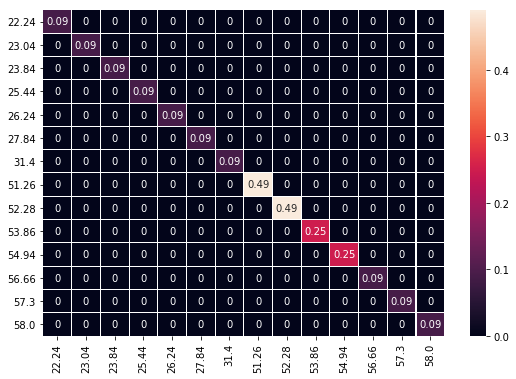

In [9]:
y_noise = pn.Series(
    [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.7, 0.7, 0.5, 0.5, 0.3, 0.3, 0.3],
    index=y_vars)
y_cor = pn.DataFrame(
    np.diag(y_noise.values**2),
    index=y_vars,
    columns=y_vars,
)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(y_cor, annot=True, fmt='g', ax=ax, linewidths=.05)

And the prior is obtained from the mean and correlation matrix of the prior. We plot them separately for T and q. Note how the Tropopause can be clearly seen.

Text(0.5, 1.0, 'Humidity [log$_{10}$(g/kg)]')

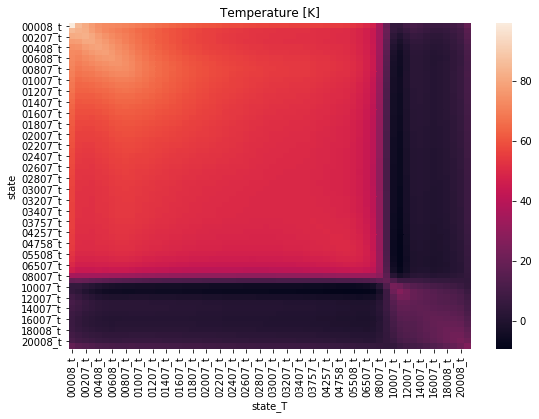

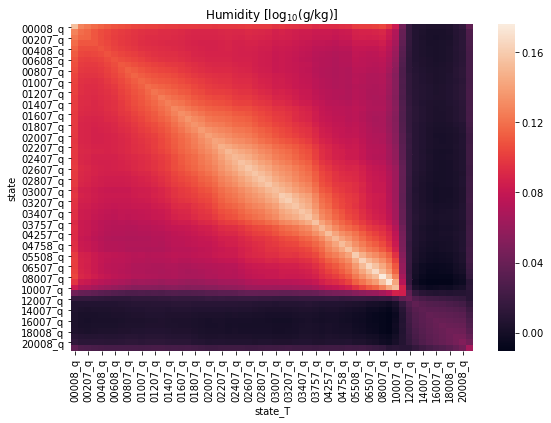

In [10]:
x_a = x_mean.sel(season=season).to_pandas()[x_vars]
x_cor = x_cov.sel(season=season).to_pandas().loc[x_vars, x_vars]

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(x_cor.iloc[1::2, 1::2], ax=ax)
ax.set_title('Temperature [K]')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(x_cor.iloc[::2, ::2], ax=ax)
ax.set_title('Humidity [log$_{10}$(g/kg)]')

Using `pyOptimalEstimation`, we create an object named `oe_ref` containing all the required information.

In [11]:
oe_ref = pyOE.optimalEstimation(
    x_vars,
    x_a,
    x_cor,
    y_vars,
    y_obs,
    y_cor,
    forwardRT,
    x_truth=x_truth.to_pandas(),
    forwardKwArgs=forwardKwArgs,
)

## run retrieval
The reference run using a prior based on December, January and February radiosondes. 

In [12]:
oe_ref.doRetrieval()

4.48 s, iteration 1, degrees of freedom: 3.70 of 120. convergence criteria NOT fullfilled  6.181
6.30 s, iteration 2, degrees of freedom: 3.68 of 120. convergence criteria fullfilled  0.044
7.95 s, iteration 3, degrees of freedom: 3.68 of 120.  Done.  0.000


True

The iterations can be visualized with `plotIterations`. The solid line is where the retrieval reached convergence, $\mathbf{x}_{truth}$ (first panel) and $\mathbf{y}_{obs}$ (second panel) are on the very right. The degrees of freedom and the convergence criterion (see Sec. 5.6.2 of Rodgers, 2000) are displayed int he third and fourth panel, respectively. In this example, the retrieval converges to a stable solution after only 2 iterations.

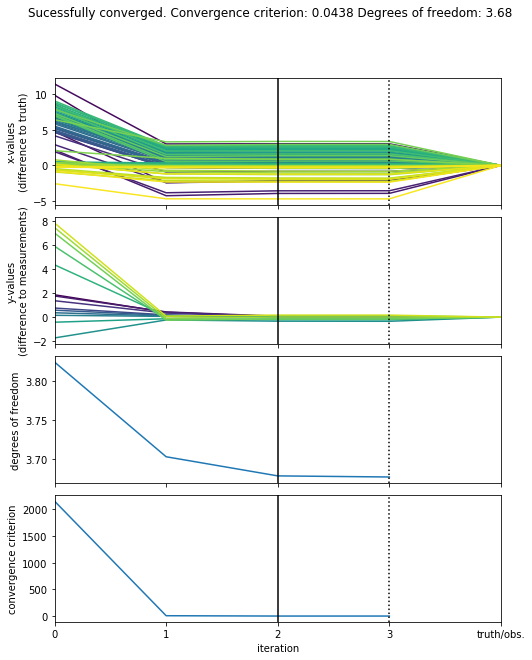

In [13]:
fig = oe_ref.plotIterations(legend=False, mode='difference')

## Analyze the results
Plot the result

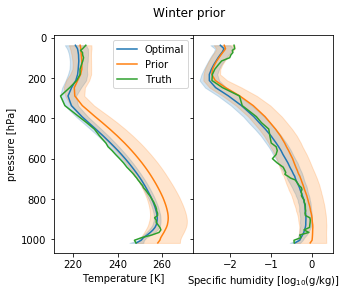

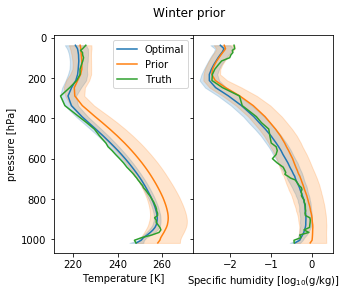

In [15]:
supporting_routines.plotMwrResults(
    oe_ref,
    h=pressure.sel(season=season) / 100,
    hlabel='pressure [hPa]',
    title='Winter prior')

Estimate the RMS for X and Y.

In [16]:
T_op, Q_op = supporting_routines.splitTQ(oe_ref.x_op)
T_truth, Q_truth = supporting_routines.splitTQ(oe_ref.x_truth)

print('RMS X: T', np.sqrt(np.mean((T_op - T_truth)**2)))
print('RMS X: Q', np.sqrt(np.mean((10**Q_op - 10**Q_truth)**2)))
print('RMS Y', np.sqrt(np.mean((oe_ref.y_obs - oe_ref.y_op)**2)))

RMS X: T 1.8188780358756458
RMS X: Q 0.07934916184554862
RMS Y 0.1372346733717641


`chiSquareTest()` makes a range of statistical tests whether 

1. $\mathbf{y}_{op}$  agrees with the measurement $\mathbf{y}_{obs}$ (Rodgers, 2000, Sec. 12.3.2) 
2. the observation $\mathbf{y}_{obs}$ agrees with the prior $\mathbb{S}_a$ (Rodgers, 2000, Sec. 12.3.3.1) 
3. the retrieved measurement | agrees with the prior $\mathbb{S}_a$ (Rodgers, 2000, Sec. 12.3.3.3) 
4. the retrieved state $\mathbf{x}_{op}$ agrees with the prior $\mathbb{S}_a$ (Rodgers, 2000, Sec. 12.3.3.2) 


In [17]:
print(oe_ref.chiSquareTest()[0])

Warning. Singular Matrix with rank 6 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 10 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


`testLinearity()` tests whether the problem is moderately linear following chapter 5.1 of Rodgers 2000. The analysis for this example is based on $\mathbf{x}_{truth}$. In case $\mathbf{x}_{truth}$ is  unknown, error patterns of $\mathbb{S}$ can be used instead. Values lower than 1 indicate that the effect of linearization is smaller than the measurement error and problem is nearly linear. 

In [18]:
print(oe_ref.linearityTest()[1] < oe_ref.linearityTest()[2])

True


# Run modified retrieval

## all seasons for prior
Use prior based on all seasons

3.47 s, iteration 1, degrees of freedom: 3.76 of 120. convergence criteria NOT fullfilled  55.343
5.40 s, iteration 2, degrees of freedom: 3.70 of 120. convergence criteria fullfilled  1.237
7.19 s, iteration 3, degrees of freedom: 3.69 of 120.  Done.  0.006
RMS X: T 2.345184630958286
RMS X: Q 0.08672875614332891
RMS Y 0.12854612367035995
Warning. Singular Matrix with rank 6 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 10 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


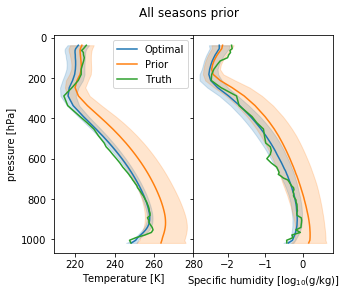

In [19]:
oe_all = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='all').to_pandas(),
    x_cov.sel(season='all').to_pandas(),
    y_vars,
    y_obs,
    y_cor,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_all.doRetrieval()

supporting_routines.plotMwrResults(
    oe_all,
    h=pressure.sel(season=season) / 100,
    hlabel='pressure [hPa]',
    title='All seasons prior')
supporting_routines.print_mwr_rms(oe_all)

print(oe_all.chiSquareTest()[0])

## summer

Use summer prior instead of winter

4.00 s, iteration 1, degrees of freedom: 3.84 of 120. convergence criteria NOT fullfilled  1232.908
5.76 s, iteration 2, degrees of freedom: 3.59 of 120. convergence criteria NOT fullfilled  91.788
7.56 s, iteration 3, degrees of freedom: 3.51 of 120. convergence criteria NOT fullfilled  2.334
9.26 s, iteration 4, degrees of freedom: 3.49 of 120. convergence criteria fullfilled  0.006
10.92 s, iteration 5, degrees of freedom: 3.49 of 120.  Done.  0.000
RMS X: T 4.888412437222851
RMS X: Q 0.19945189284423864
RMS Y 0.3253269706674038
Warning. Singular Matrix with rank 6 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 10 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool


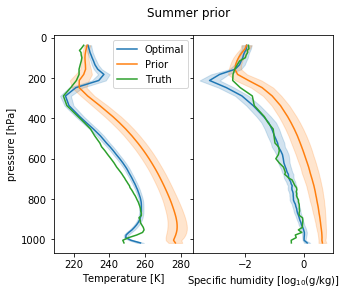

In [20]:
oe_sum = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season='JJA').to_pandas(),
    x_cov.sel(season='JJA').to_pandas(),
    y_vars,
    y_obs,
    y_cor,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_sum.doRetrieval()

supporting_routines.plotMwrResults(
    oe_sum,
    h=pressure.sel(season=season) / 100,
    hlabel='pressure [hPa]',
    title='Summer prior')
supporting_routines.print_mwr_rms(oe_sum)

print(oe_sum.chiSquareTest()[0])

## diagonal prior

3.35 s, iteration 1, degrees of freedom: 3.37 of 120. convergence criteria NOT fullfilled  2.641
5.11 s, iteration 2, degrees of freedom: 3.35 of 120. convergence criteria fullfilled  0.005
6.84 s, iteration 3, degrees of freedom: 3.35 of 120.  Done.  0.000
RMS X: T 3.714774189363847
RMS X: Q 0.10871968194287557
RMS Y 0.4023741654561554
Warning. Singular Matrix with rank 6 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 12 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool


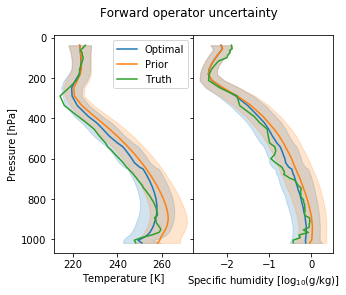

In [21]:
oe_diag = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season=season).to_pandas(),
    np.diag(np.diag(x_cov.sel(season=season))),
    y_vars,
    y_obs,
    y_cor,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_diag.doRetrieval()

supporting_routines.plotMwrResults(
    oe_diag,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='Forward operator uncertainty')
supporting_routines.print_mwr_rms(oe_diag)

print(oe_diag.chiSquareTest()[0])

## Forward operator uncertainty

Add errors of D. Cimini's study:

In [22]:
Syb = pn.DataFrame(
    np.array([
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.1, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 3.0, 3.3, 1.2, 0.3, 0.0, 0.0, 0.0],
        [0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.7, 8.7, 9.2, 0.3, 0.3, 0.0, 0.0, 0.0],
        [0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.7, 8.2, 8.7, 0.3, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.7, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
    ]),
    index=frequencies[::-1],
    columns=frequencies)

Text(0.5, 1.0, 'Model uncertainty in $\\mathbf{y}$ space')

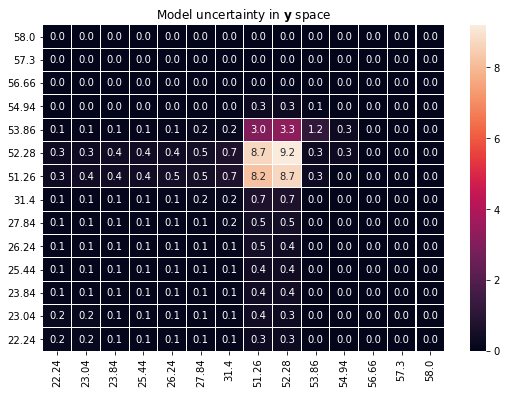

In [23]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(Syb, annot=True, linewidths=.05, ax=ax, fmt='.1f')
ax.set_title('Model uncertainty in $\mathbf{y}$ space')

3.33 s, iteration 1, degrees of freedom: 3.28 of 120. convergence criteria fullfilled  1.268
5.02 s, iteration 2, degrees of freedom: 3.25 of 120.  Done.  0.008
RMS X: T 2.2936431040279275
RMS X: Q 0.09197696593155433
RMS Y 0.22561970504145332
Warning. Singular Matrix with rank 6 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 10 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


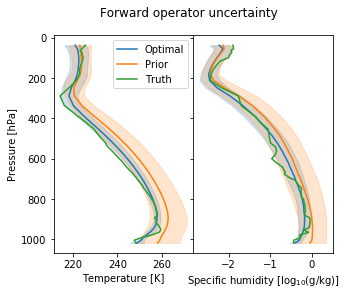

In [24]:
oe_b = pyOE.optimalEstimation(
    x_vars,
    x_mean.sel(season=season).to_pandas(),
    x_cov.sel(season=season).to_pandas(),
    y_vars,
    y_obs,
    y_cor + Syb,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_b.doRetrieval()
supporting_routines.plotMwrResults(
    oe_b,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='Forward operator uncertainty')
supporting_routines.print_mwr_rms(oe_b)

print(oe_b.chiSquareTest()[0])

# Plot degrees of freedom. 

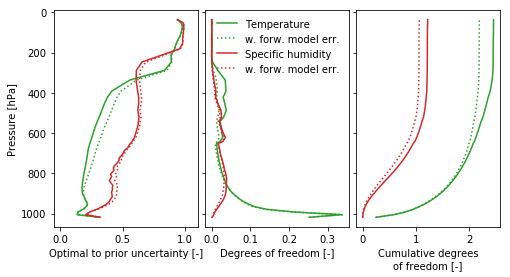

In [25]:
fig, (axA, axB, axC) = plt.subplots(ncols=3, sharey=True, figsize=(8, 4))

T, Q = supporting_routines.splitTQ(oe_ref.x_op_err / oe_ref.x_a_err)
T_e, Q_e = supporting_routines.splitTQ(oe_b.x_op_err / oe_b.x_a_err)

axA.plot(T, pressure.sel(season=season) / 100, color='C2', label='Temperature')
axA.plot(
    T_e,
    pressure.sel(season=season) / 100,
    color='C2',
    ls=':',
    label='w. forw. model err.')

axA.plot(
    Q,
    pressure.sel(season=season) / 100,
    color='C3',
    label='Specific humidity')
axA.plot(
    Q_e,
    pressure.sel(season=season) / 100,
    color='C3',
    ls=':',
    label='w. forw. model err.')

T, Q = [(x) for x in supporting_routines.splitTQ(oe_ref.dgf_x)]
T_e, Q_e = [(x) for x in supporting_routines.splitTQ(oe_b.dgf_x)]

axB.plot(T, pressure.sel(season=season) / 100, color='C2', label='Temperature')
axB.plot(
    T_e,
    pressure.sel(season=season) / 100,
    color='C2',
    ls=':',
    label='w. forw. model err.')

axB.plot(
    Q,
    pressure.sel(season=season) / 100,
    color='C3',
    label='Specific humidity')
axB.plot(
    Q_e,
    pressure.sel(season=season) / 100,
    color='C3',
    ls=':',
    label='w. forw. model err.')

T, Q = [np.cumsum(x) for x in supporting_routines.splitTQ(oe_ref.dgf_x)]
T_e, Q_e = [np.cumsum(x) for x in supporting_routines.splitTQ(oe_b.dgf_x)]

axC.plot(T, pressure.sel(season=season) / 100, color='C2', label='Temperature')
axC.plot(
    T_e,
    pressure.sel(season=season) / 100,
    color='C2',
    ls=':',
    label='w. forw. model err.')

axC.plot(
    Q,
    pressure.sel(season=season) / 100,
    color='C3',
    label='Specific humidity')
axC.plot(
    Q_e,
    pressure.sel(season=season) / 100,
    color='C3',
    ls=':',
    label='w. forw. model err.')



axB.legend(frameon=False)
axC.set_xlabel('Cumulative degrees\nof freedom [-]')
axB.set_xlabel('Degrees of freedom [-]')
axA.set_xlabel('Optimal to prior uncertainty [-]')

axA.set_ylabel('Pressure [hPa]')
axA.invert_yaxis()
axA.set_xlim(-0.05,1.1)
fig.subplots_adjust(wspace=0.05)

# References

* Löhnert, U., S. Crewell, and C. Simmer, 2004: An Integrated Approach toward Retrieving Physically Consistent Profiles of Temperature, Humidity, and Cloud Liquid Water. J. Appl. Meteor., 43, 1295–1307, [https://doi.org/10.1175/1520-0450(2004)043<1295:AIATRP>2.0.CO;2](https://doi.org/10.1175/1520-0450(2004)043<1295:AIATRP>2.0.CO;2).